In [1]:
%load_ext autoreload
%autoreload 2

from text3d2video.pipelines.pipeline_utils import load_pipeline
import torch
from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.pipelines.controlnet_pipeline import BaseControlNetPipeline

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
device = 'cuda'
pipe = load_pipeline(BaseControlNetPipeline, sd_repo, controlnet_repo)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [2]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.rendering import render_depth_map

rumba = AnimationArtifact.from_wandb_artifact_tag("rumba:latest")

cam, mesh = rumba.load_frames(1)
depth = render_depth_map(mesh, cam)[0]

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:01<00:00, 15.71it/s]


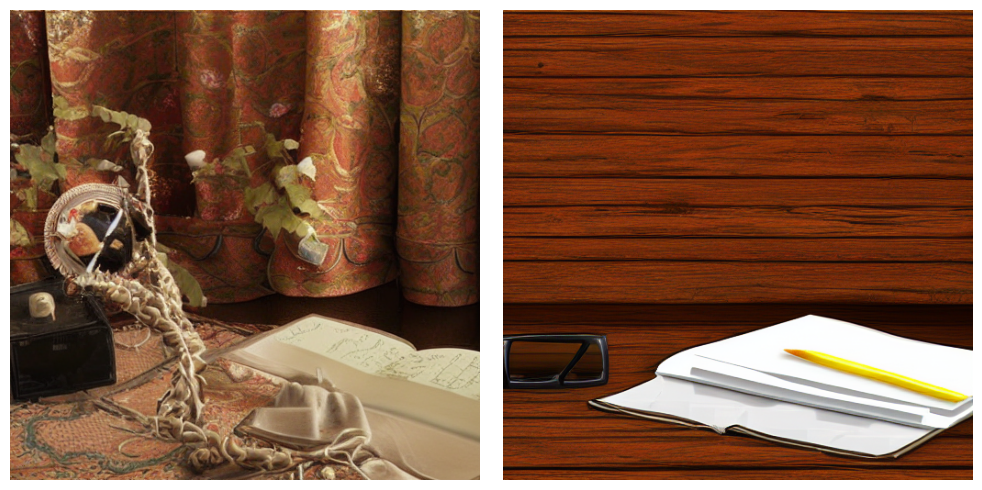

In [22]:
prompt = "An academic, mathematical research paper on a table. high quality, photorealistic"
seed = 1

gen = torch.Generator(device=device)
gen.manual_seed(seed)

im_no_guidance = pipe(
    [prompt],
    [depth],
    generator=gen,
    num_inference_steps=30,
    guidance_scale=1,
    controlnet_conditioning_scale=0,
)[0]

gen = torch.Generator(device=device)
gen.manual_seed(seed)

im_guided = pipe(
    [prompt],
    [depth],
    generator=gen,
    num_inference_steps=30,
    guidance_scale=6,
    controlnet_conditioning_scale=0,
)[0]

display_ims([im_no_guidance, im_guided], scale=5)